<a href="https://colab.research.google.com/github/Rad-Monk/TF-Notebooks/blob/main/Vision_IC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

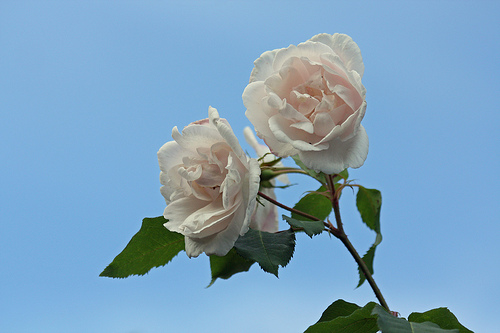

In [ ]:
roses = list(data_dir.glob('roses/*.jpg'))
PIL.Image.open(str(roses[1]))

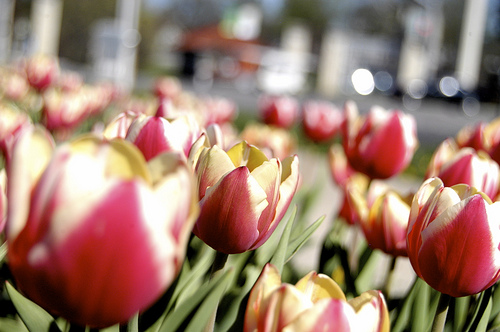

In [ ]:
tulips = list(data_dir.glob('tulips/*.jpg'))
PIL.Image.open(str(tulips[0]))

In [ ]:
batch_size = 32
image_height = 180
image_width = 180

In [ ]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = .2,
    subset = 'training',
    seed = 123,
    batch_size = batch_size,
    image_size = (image_height, image_width)
)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = .2,
    subset = 'validation',
    seed = 123,
    batch_size = batch_size,
    image_size = (image_height, image_width)
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_name = raw_train_ds.class_names
class_name

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
import matplotlib.pyplot as plt

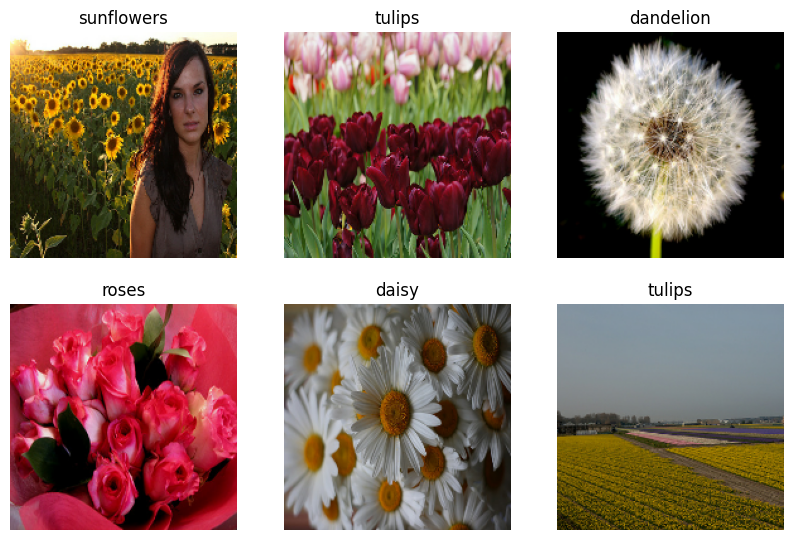

In [ ]:
plt.figure(figsize = (10,10))
for images,labels in raw_train_ds.take(1):
  for i in range(6):
    ax= plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis('off')

In [ ]:
for image_batch,label_batch in raw_train_ds.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
raw_train_ds = raw_train_ds.cache().shuffle(100).prefetch(buffer_size = AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = raw_train_ds.map(lambda x,y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
print(image_batch.shape)

(32, 180, 180, 3)


In [ ]:
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes= len(class_name)

model = tf.keras.Sequential([
    normalization_layer,
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation = 'relu', input_shape = (image_height, image_width, 3 )),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer = 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = 'accuracy'
)


In [ ]:
history = model.fit(
    raw_train_ds,
    validation_data = raw_val_ds,
    epochs = 10,
)

Epoch 1/10
92/92 [==============================] - 126s 1s/step - loss: 1.2429 - accuracy: 0.4601 - val_loss: 1.0533 - val_accuracy: 0.5668
Epoch 2/10
92/92 [==============================] - 139s 2s/step - loss: 0.9503 - accuracy: 0.6247 - val_loss: 0.9769 - val_accuracy: 0.5749
Epoch 3/10
92/92 [==============================] - 144s 2s/step - loss: 0.7423 - accuracy: 0.7187 - val_loss: 0.8563 - val_accuracy: 0.6553
Epoch 4/10
92/92 [==============================] - 134s 1s/step - loss: 0.5407 - accuracy: 0.8004 - val_loss: 0.8738 - val_accuracy: 0.6717
Epoch 5/10
92/92 [==============================] - 149s 2s/step - loss: 0.3511 - accuracy: 0.8804 - val_loss: 0.9543 - val_accuracy: 0.6635
Epoch 6/10
92/92 [==============================] - 141s 2s/step - loss: 0.1785 - accuracy: 0.9428 - val_loss: 1.1217 - val_accuracy: 0.6757
Epoch 7/10
92/92 [==============================] - 140s 2s/step - loss: 0.0821 - accuracy: 0.9796 - val_loss: 1.3400 - val_accuracy: 0.6553
Epoch 8/10
92

Text(0.5, 1.0, 'Training and Validation Accuracy')

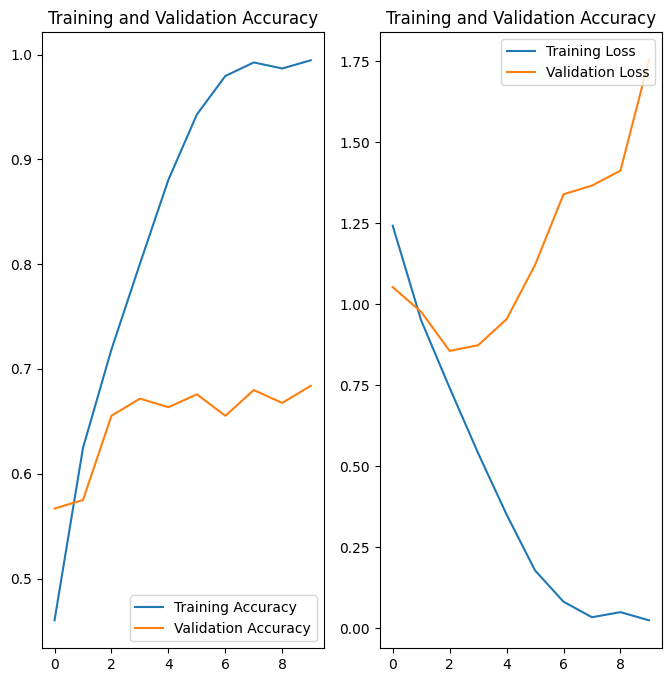

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(
        'horizontal',
        input_shape = (image_height, image_width, 3)
    ),
    layers.RandomRotation(.1),
    layers.RandomZoom(.1)
])

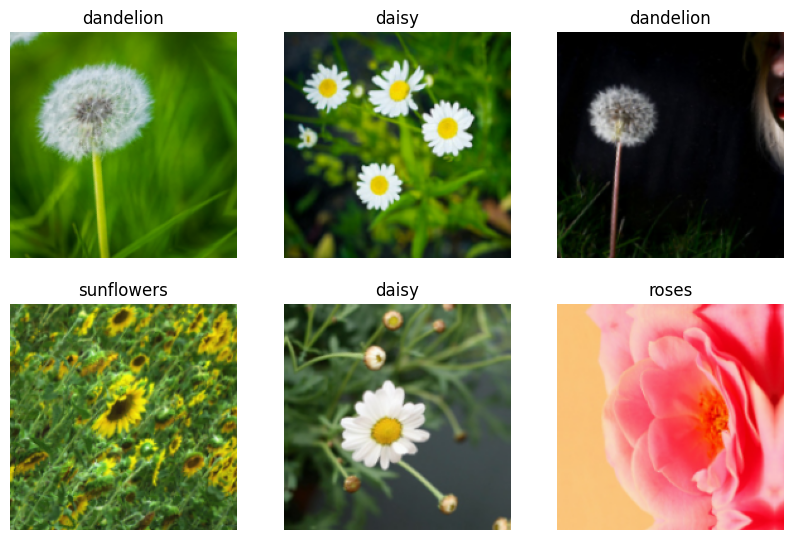

In [ ]:
plt.figure(figsize=(10,10))
for images,labels in raw_train_ds.take(1):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax= plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis('off')

In [ ]:
model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape = (image_height, image_width, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [ ]:
history= model.fit(
    raw_train_ds,
    validation_data = raw_val_ds,
    epochs = 10
)

Epoch 1/10
92/92 [==============================] - 156s 2s/step - loss: 0.6205 - accuracy: 0.7660 - val_loss: 0.7673 - val_accuracy: 0.7125
Epoch 2/10
92/92 [==============================] - 125s 1s/step - loss: 0.5818 - accuracy: 0.7684 - val_loss: 0.7636 - val_accuracy: 0.7153
Epoch 3/10
92/92 [==============================] - 117s 1s/step - loss: 0.5474 - accuracy: 0.7926 - val_loss: 0.8064 - val_accuracy: 0.6975
Epoch 4/10
92/92 [==============================] - 119s 1s/step - loss: 0.5267 - accuracy: 0.8045 - val_loss: 0.8149 - val_accuracy: 0.7221
Epoch 5/10
92/92 [==============================] - 118s 1s/step - loss: 0.5211 - accuracy: 0.8045 - val_loss: 0.7275 - val_accuracy: 0.7330
Epoch 6/10
92/92 [==============================] - 121s 1s/step - loss: 0.4910 - accuracy: 0.8120 - val_loss: 0.7318 - val_accuracy: 0.7221
Epoch 7/10
92/92 [==============================] - 121s 1s/step - loss: 0.4607 - accuracy: 0.8324 - val_loss: 0.6948 - val_accuracy: 0.7371
Epoch 8/10
92

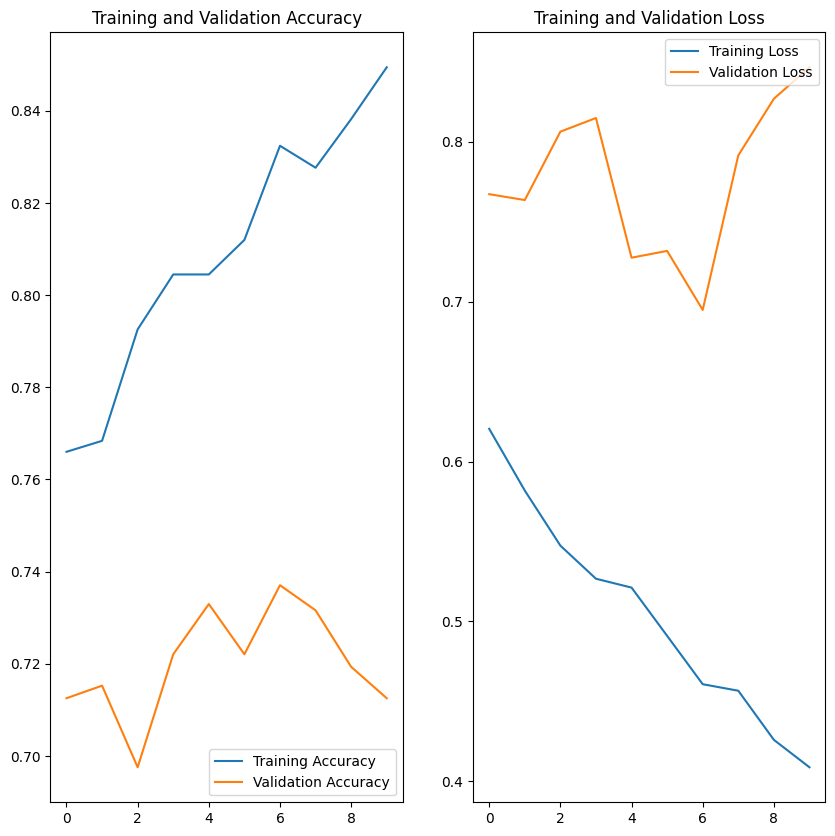

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.plot(epochs_range, accuracy, label ='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img= tf.keras.utils.load_img(
    sunflower_path, target_size = (image_height, image_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction= model.predict(img_array)
score = tf.nn.softmax(prediction[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_name[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 298ms/step
This image most likely belongs to sunflowers with a 99.92 percent confidence.


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tf_lite_model)

In [ ]:
TF_MODEL_PATH = 'model_tflite'
interpretor = tf.lite.Interpreter(TF_MODEL_PATH)

ValueError: Could not open 'model_tflite'.

In [ ]:
interpretor.get_signature_list()

In [ ]:
classify_lite = interpretor.get_signature_runner('serving_default')
classify_lite

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_name[np.argmax(score_lite)], 100 * np.max(score_lite))
)

NameError: name 'score_lite' is not defined

In [ ]:
print(np.max(np.abs(prediction - predictions_lite)))

NameError: name 'predictions_lite' is not defined